# Basic Power Consumption / Capacity Analysis #

The Aretas platform stores the time series voltage / current and instantaneuos kw data from the BESS over time. As such, we can integrate over this data to estimate the total power in/out. In the chart below we can see the purple line denoting the current in/out and the voltage changes. 

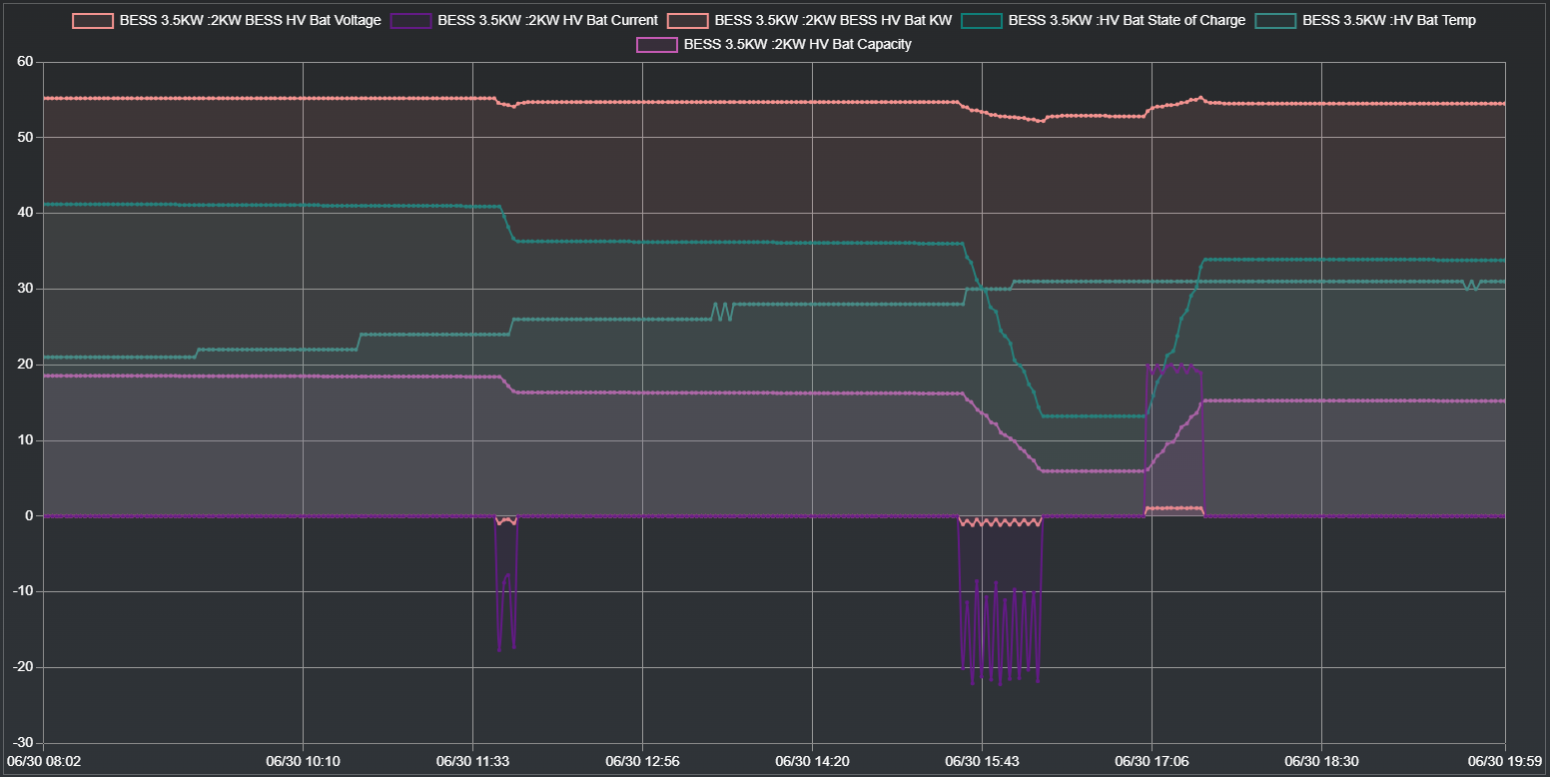

In this way, we can compute an estimate of capacity. 

Why do we want to estimate the total power input / output from the battery over time? This allows us to:

1. Compute the cost of power usage over a time span (negative or positve)
2. Estimate the battery capacity (Ah / KWh)
3. Develop algorithms to predict the degradation of the battery over time
4. Develop algorithms to optimize BESS battery life

Computing the capacity should be:

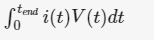

Realistically, this will be the Riemann Sum approximation and we should use the trapezoidal rule over dt for best approximation. 

We will use the Aretas Python API to fetch data from the API and test the algorithm. 

In [50]:
import os
import sys
from datetime import datetime
from AretasPythonAPI.api_config import *
from AretasPythonAPI.sensor_data_query import *
from AretasPythonAPI.auth import *
from AretasPythonAPI.aretas_client import *
from AretasPythonAPI.sensor_type_info import *
from AretasPythonAPI.utils import Utils as AUtils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

## Connect to the API and List Devices ##

A quick refresher to demonstrate how to connect to the API and list active devices. 

In [51]:
config_path = os.getcwd() + "\\config.cfg"
config = APIConfig(config_path=config_path)
auth = APIAuth(config)
client = APIClient(auth)

# we will almost always need the sensortypeinfo class
sensor_type_info = APISensorTypeInfo(auth)

client_location_view = client.get_client_location_view()

my_client_id = client_location_view['id']
all_macs = client_location_view['allMacs']
my_devices_and_locations = client_location_view['locationSensorViews']

active_locs = client.get_active_locations()
active_locs_objs = [loc['location'] for loc in active_locs]
# show locations with active devices
print("\nLocations with active devices:")
for active in active_locs_objs:
    print("Description: {0} Country: {1} State/Province: {2} City: {3} Lat: {4} Lon: {5}".format(
        active['description'],
        active['country'],
        active['state'],
        active['city'],
        active['lat'],
        active['lon']))

print("\nActive Devices:")
active_devices = client.get_active_devices()
for active_device in active_devices:
    print("Description: {0} Mac: {1} Lat: {2} Lon: {3}".format(
        active_device['description'],
        active_device['mac'],
        active_device['lat'],
        active_device['lon']))


Locations with active devices:
Description: Rainhouse R&D 2 Country: Canada State/Province: BC City: Qualicum Beach Lat: 49.32876 Lon: -124.55771
Description: Rainhouse Manufacturing Country: Canada State/Province: BC City: Victoria Lat: 48.43211 Lon: -123.38891
Description: Rainhouse Manufacturing BESS Country: Canada State/Province: BC City: Victoria Lat: 48.43211 Lon: -123.38891

Active Devices:
Description: BESS 3.5KW - ENV Mac: 7725398 Lat: 49.32876 Lon: -124.55771
Description: BESS 3.5KW  Mac: 303721690 Lat: 49.32876 Lon: -124.55771
Description: BESS 10KW Mac: 303721691 Lat: 48.43211 Lon: -123.38891
Description: Puma 240M Lathe Mac: 3162989 Lat: 48.43211 Lon: -123.38891
Description: Matsuura Mac: 14339560 Lat: 48.43211 Lon: -123.38891
Description: Fanuc Robodrill Mac: 16624087 Lat: 48.43211 Lon: -123.38891
Description: Nakamura-Tome WT 150ii Lathe Mac: 14302884 Lat: 48.43211 Lon: -123.38891


## Query some data and plot it ##

The config file also contains our self mac for this BESS. If you want to query another BESS, change the MAC.

In [52]:
mac = int(config.get_value('self_mac'))
print(mac)

303721690


In [53]:
sdq = SensorDataQuery(auth)

In [54]:
def fn_date_conv(x):
    """
     convert the csv Datetime to a python datetime object
    """
    print(x)
    dt = datetime.strptime(x, '%m/%d/%Y %H:%M:%S')
    return int(dt.timestamp() * 1000)


dt1 = "06/30/2023 08:02:00"
dt2 = "06/30/2023 19:59:00"

start = fn_date_conv(dt1)
end   = fn_date_conv(dt2)

sensor_data = sdq.get_data(mac=mac, begin=start, end=end)

sensor_data[0:10]

06/30/2023 08:02:00
06/30/2023 19:59:00
https://iot.aretas.ca/rest/sensordata/byrange?mac=303721690&begin=1688137320000&end=1688180340000&limit=1000000&offsetData=False


[{'mac': 303721690, 'type': 532, 'timestamp': 1688137326776, 'data': 55.2},
 {'mac': 303721690, 'type': 531, 'timestamp': 1688137327197, 'data': 0.0},
 {'mac': 303721690, 'type': 533, 'timestamp': 1688137327615, 'data': 0.0},
 {'mac': 303721690, 'type': 514, 'timestamp': 1688137328081, 'data': 41.2},
 {'mac': 303721690, 'type': 520, 'timestamp': 1688137328586, 'data': 21.0},
 {'mac': 303721690, 'type': 530, 'timestamp': 1688137329055, 'data': 18.54},
 {'mac': 303721690, 'type': 532, 'timestamp': 1688137346776, 'data': 55.2},
 {'mac': 303721690, 'type': 531, 'timestamp': 1688137347218, 'data': 0.0},
 {'mac': 303721690, 'type': 533, 'timestamp': 1688137347628, 'data': 0.0},
 {'mac': 303721690, 'type': 514, 'timestamp': 1688137348070, 'data': 41.2}]

In [22]:
sensor_data_reshaped = dict[int, list[dict[int, float]]]()
for datum in sensor_data:
    if datum['type'] not in sensor_data_reshaped:
        sensor_data_reshaped[datum['type']] = list[dict[int, float]]()
    sensor_data_reshaped[datum['type']].append({
        'timestamp': datum['timestamp'], 'data': datum['data']
    })

sensor_data_reshaped[532]0:10]
    

[{'timestamp': 1688137326776, 'data': 55.2},
 {'timestamp': 1688137346776, 'data': 55.2},
 {'timestamp': 1688137366776, 'data': 55.2},
 {'timestamp': 1688137386780, 'data': 55.2},
 {'timestamp': 1688137406780, 'data': 55.2},
 {'timestamp': 1688137426780, 'data': 55.2},
 {'timestamp': 1688137446776, 'data': 55.2},
 {'timestamp': 1688137466776, 'data': 55.2},
 {'timestamp': 1688137486784, 'data': 55.2},
 {'timestamp': 1688137506788, 'data': 55.2}]

In [40]:
df = pd.DataFrame(sensor_data)

In [41]:
df.head(5)

,mac,type,timestamp,data
0,303721690,532,1688137326776,55.2
1,303721690,531,1688137327197,0.0
2,303721690,533,1688137327615,0.0
3,303721690,514,1688137328081,41.2
4,303721690,520,1688137328586,21.0


In [42]:
datetime.utcfromtimestamp(1688137326776/1000).strftime('%d-%m-%Y %H:%M:%S.%f')

'30-06-2023 15:02:06.776000'

In [45]:
def convert_ts(ts):
    ts = ts / 1000
    # print(ts)
    return str(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S.%f'))

def convert_sensor_label(sensor_type:int):
    sensor_type_obj = 

df['datetime'] = df['timestamp'].apply(convert_ts)

df.head(3)

,mac,type,timestamp,data,datetime
0,303721690,532,1688137326776,55.2,2023-06-30 15:02:06.776000
1,303721690,531,1688137327197,0.0,2023-06-30 15:02:07.197000
2,303721690,533,1688137327615,0.0,2023-06-30 15:02:07.615000


In [48]:
fig = px.line(df, x='datetime', y='data', color='type', width=1024, height=800)
fig.show()